The generated images below may slightly differ from those in the paper, but this does not impact our main conclusions. The discrepancy is primarily due to differences in the sorting of items with the same count by the value_counts function.

In [ ]:
import os
import sys
from pathlib import Path

# Set root and data directories
ROOT_DIR = Path(os.getcwd()).resolve().parent.parent
sys.path.insert(0, str(ROOT_DIR))
from path import DATA_DIR

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)

# Set plot directory
os.chdir(DATA_DIR / f"result_2025/down_stream_analysis")



ROOT_DIR: /root/project/reproducity
DATA_DIR: /data/sequential_data


In [2]:
import pickle
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use("Agg")

mpl.rcParams.update({
    "axes.labelsize": 7,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "legend.frameon": False,
    "legend.fontsize": 3,
    "axes.linewidth": 0.5,
    "pdf.fonttype": 42,
    "figure.dpi": 300,
})
%matplotlib inline


## 1. Read and processes MoA data
MoA data for multiple cell lines and computes statistics for the top 10 most frequent MoAs in each class. 

In [3]:
import pickle
import numpy as np
import pandas as pd
from itertools import chain

# List of cell lines to process
all_ccls = ["A375", "MDAMB231", "SKBR3", "MCF7", "HS578T", "BT20", "HEPG2", "HCC515", "A549", "HUH7"]
all_res = []

# Process each cell line
for cell_line in all_ccls:
    # Load MoA data for the current cell line
    MoA_file_name = f"MoA_res/{cell_line}.pkl"
    with open(MoA_file_name, "rb") as f:
        MoA_dict = pickle.load(f)

    # Concatenate all MoA DataFrames for the cell line
    ccl_MoA_res = pd.concat(list(MoA_dict.values()))

    # Generate class labels for each MoA entry (based on the class)
    class_labels = [
        ["class" + str(i+1)] * df.shape[0] for i, df in enumerate(list(MoA_dict.values())) if df.shape[0] != 0
    ]
    class_labels = list(chain.from_iterable(class_labels))  # Flatten the list

    # Add class labels to the merged MoA DataFrame
    ccl_MoA_res["class"] = class_labels
    all_res.append(ccl_MoA_res)  # Append the result for the current cell line

# Merge results from all cell lines into a single DataFrame
all_res = pd.concat(all_res)
all_res.index = np.arange(all_res.shape[0])  # Reset index

# Prepare data for scatter plot (show top `n` MoAs)
top_n = len(all_res['MoA'].unique())  # Number of unique MoAs
temp = all_res.drop_duplicates(["MoA", "class"]).value_counts("MoA")  # Count MoA occurrences
MoA_keys = list(temp.index)[:top_n]  # Top `n` MoAs
MoA_vals = temp.values[:top_n]  # Corresponding counts of top MoAs

# Create dictionaries for MoA and class indices
MoA_dict = {key: value for key, value in zip(MoA_keys, list(range(top_n, 0, -1)))}
class_dict = {key: value for key, value in zip([f"class{i}" for i in range(1, 8)], np.arange(1, 8))}

# Update MoA names based on an external file (mapping old names to new names)
MoA_dict_new = {}
MoA_change_df = pd.read_excel(ROOT_DIR.parent / "data/drug_type_name_modify.xlsx")

# Clean and modify MoA names
MoA_change_df.iloc[:, 0] = [MoA_change_df.iloc[i, 0][2:] for i in range(MoA_change_df.shape[0])]
MoA_change_df.index = MoA_change_df.iloc[:, 0]  # Set the modified MoA names as index

# Update MoA dictionary with new names
for k, v in MoA_dict.items():
    new_k = MoA_change_df.loc[k, "new name"].strip()  # Get the new name
    MoA_dict_new[new_k] = v  # Add the updated mapping

# Update the MoA dictionary
MoA_dict = MoA_dict_new
MoA_keys_list = list(MoA_dict.keys())
MoA_keys = np.array(MoA_keys_list)  # Get updated MoA keys

# Merge new MoA names into the all_res DataFrame
MoA_change_df = MoA_change_df.reset_index(drop=True)
all_res_newname = pd.merge(MoA_change_df, all_res, left_on='original name', right_on='MoA')

# Clean the DataFrame by dropping unnecessary columns
all_res_newname.drop(columns=['original name', 'new name (Chinese)', 'MoA'], inplace=True)
all_res = all_res_newname.rename(columns={'new name': 'MoA'})

# Strip any leading or trailing spaces in the 'MoA' column
all_res['MoA'] = all_res['MoA'].str.strip()


## 2. Create plot data

In [4]:
x_arr = []
y_arr = []
val_arr = []
p_arr = []
pair_arr = []
for i in range(all_res.shape[0]):
    if all_res.iloc[i, 0] in MoA_dict.keys():
        x_arr.append(class_dict[all_res.iloc[i, -1]])
        y_arr.append(MoA_dict[all_res.iloc[i, 0]])
        pair_arr.append((class_dict[all_res.iloc[i, -1]],MoA_dict[all_res.iloc[i, 0]]))
        val_arr.append(all_res.iloc[i, 3])
        p_arr.append(all_res.iloc[i, 4])
val_arr_norm = list(val_arr/np.max(val_arr))

## plot

In [5]:
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(6, 6), gridspec_kw={'width_ratios': [2, 1.5, 1]})

# ======= 1. Scatter Plot (Bubble Heatmap) =======
scatter = axes[0].scatter(
    x_arr, y_arr, alpha=0.6, sizes=np.array(val_arr_norm) * 90, 
    edgecolors="#323232", linewidths=0.5, c=-np.array(p_arr), cmap="Blues", vmin=-0.05
)

# X-axis settings (Cell lines)
axes[0].set_xticks(np.arange(1, len(class_dict) + 1))
axes[0].set_xticklabels(list(class_dict.keys()), rotation=45, ha='right')  # Removed Arial font
axes[0].tick_params(axis='x', direction='out', length=1)

# Y-axis settings (Pathways)
axes[0].set_ylim([0.5, top_n + 0.8])
axes[0].set_yticks(np.arange(1, top_n + 1))
axes[0].yaxis.tick_right()
axes[0].set_yticklabels([" "] * top_n)
axes[0].tick_params(axis='y', direction='out', length=1)

# Plot title
axes[0].set_title("Drug type of drug A", fontsize=7)  # Removed Arial font

# Add grid lines
for i in range(1, len(class_dict) + 1):
    axes[0].axvline(x=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)
for i in range(top_n + 1):
    axes[0].axhline(y=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)

# ======= 2. Color and Size Legends =======
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_xaxis().set_visible(False)

# Y-axis settings for MoA names
axes[1].set_ylim([0.5, top_n + 0.8])
axes[1].set_yticks(np.arange(1, top_n + 1))
axes[1].set_yticklabels(MoA_keys[::-1], ha="left")  # Removed Arial font
axes[1].tick_params(axis='y', direction='out', length=0)

# Add colorbar
cax = fig.add_axes([1, 0.5, 0.02, 0.2]) 
cbar = plt.colorbar(scatter, ax=axes[0], cax=cax)
cbar.set_label('color_arr', fontsize=5)  # Removed Arial font

# Add size legend
legend_sizes = [90, 45, 9]
legend_labels = ['1.0', '0.5', '0.1']
scatter_legend = [
    axes[1].scatter([], [], s=size, label=label, edgecolors="#323232", linewidths=0.5, color='black')
    for size, label in zip(legend_sizes, legend_labels)
]
axes[1].legend(
    handles=scatter_legend, 
    title='', 
    bbox_to_anchor=(2.35, 1.05), 
    loc='best',
    labelspacing=1.2,  # Increase space between legend entries
    fontsize=8  # Adjust font size to avoid overlapping
)

# ======= 3. Horizontal Bar Chart (Pathway Count) =======
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].barh(np.arange(1, top_n + 1), MoA_vals[::-1], align="center", color='#5D80AA')

# Y-axis settings
axes[2].set_ylim([0.5, top_n + 0.8])
axes[2].set_yticks(np.arange(1, top_n + 1))
axes[2].set_yticklabels([" "] * top_n)
axes[2].tick_params(axis='y', direction='out', length=1)

# X and Y axis settings for bar chart
axes[2].tick_params(axis='x', direction='out', length=1)
axes[2].set_title("Count", fontsize=7)  # Removed Arial font

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.1)


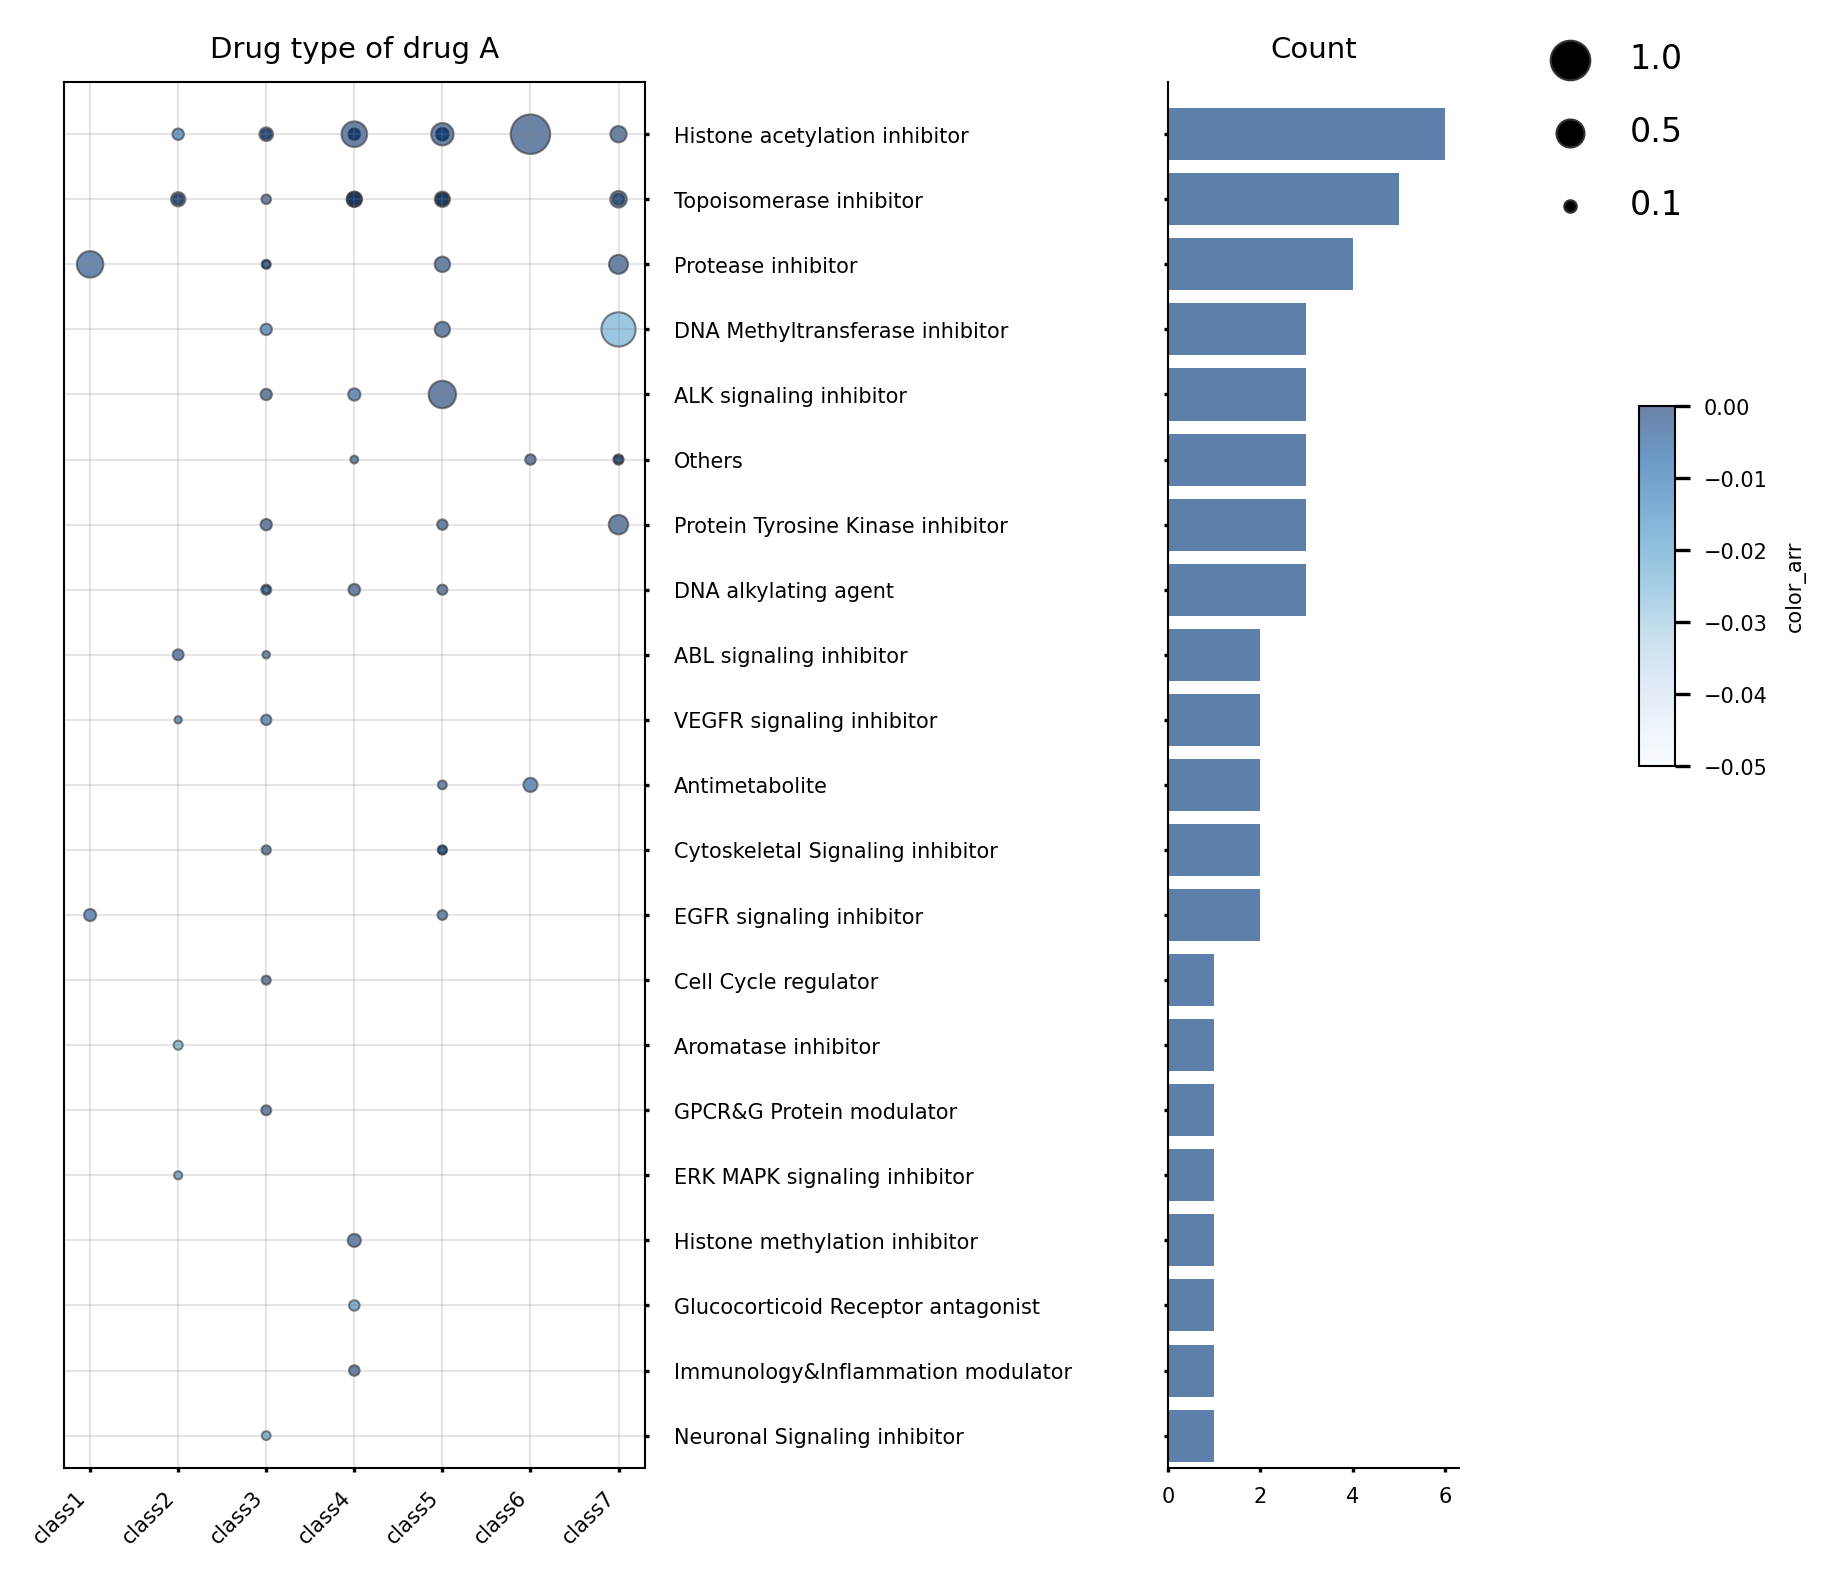

In [6]:
plt.show()